In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#miscellaneous imports for the project
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt # for plotting

import numpy as np

import os
from glob import glob
import time

from PIL import Image
import json
import cv2

In [3]:
#load a subset of the data
#using the HanCo tester: 1 person, 8 camera angles, 67 images at each angle, 5 different sets (backgrounds) ~= 2680 images
#train loader - image then tuple of coordinates in 2d space (i.e. where they would be overlayed on an image)

base_dir = "/content/drive/MyDrive/Colab Notebooks/Datasets/mini_project_dataset/HanCo_tester"
folders = ["rgb", "rgb_color_auto", "rgb_color_sample", "rgb_homo", "rgb_merged"]

all_images = []

for folder in folders:
  pattern = os.path.join(base_dir, folder, "*", "cam*", "*.jpg")
  all_images.extend(glob(pattern))

print(f"found {len(all_images)} images")

train_val, test = train_test_split(all_images, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.2, random_state=42)  # 20% of train_val -> val

print(len(train), len(val), len(test))


found 2680 images
1929 483 268


In [63]:
class HandDataset(Dataset):
    def __init__(self, image_paths, xyz_root, transform=None):
        self.image_paths = image_paths
        self.xyz_root = xyz_root  # now required
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        camera_idx = int(os.path.basename(os.path.dirname(img_path))[3:])
        frame_num = int(os.path.basename(img_path).split(".")[0])

        # Load corresponding xyz keypoints
        frame_num = os.path.basename(img_path).split(".")[0]  # e.g., '00000006'
        xyz_path = os.path.join(self.xyz_root, frame_num + ".json")
        if not os.path.exists(xyz_path):
            raise FileNotFoundError(f"Missing xyz file for frame {frame_num}")
        with open(xyz_path, "r") as f:
            xyz = json.load(f)
        xyz = torch.tensor(xyz, dtype=torch.float32)

#changing the relative xyz coordinates of the dataset to 2D xy coordinates relative to the picture itself
        xyz = xyz.numpy()

        calib_dir = base_dir + r"/calib/0110"
        # Load every calibration file into a list of dicts
        calib = [
            json.load(open(os.path.join(calib_dir, name)))
            for name in os.listdir(calib_dir)
            if name.endswith(".json")
        ]

        if(frame_num[0:6] == "0000000"):
            frame_idx = int(frame_num[-1:])
        else:
            frame_idx = int(frame_num[-2:])

        K_all = np.array(calib[frame_idx]["K"])
        M_all = np.array(calib[frame_idx]["M"])
        K = np.array(K_all[camera_idx])
        M = np.array(M_all[camera_idx])

        # Project to camera
        R = M[:3, :3]
        t = M[:3, 3]
        X_cam = (R @ xyz.T + t[:, None]).T
        proj = (K @ X_cam.T).T
        uv = proj[:, :2] / proj[:, 2, None]
        uv = uv/224
        uv = torch.tensor(uv, dtype=torch.float32)

        return {"image": img, "xy": uv}

In [64]:
#making the data loaders for training, validation, testing

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = HandDataset(train, xyz_root=os.path.join(base_dir, "xyz/0110"), transform=transform)
val_dataset = HandDataset(val, xyz_root=os.path.join(base_dir, "xyz/0110"), transform=transform)
test_dataset = HandDataset(test, xyz_root=os.path.join(base_dir, "xyz/0110"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


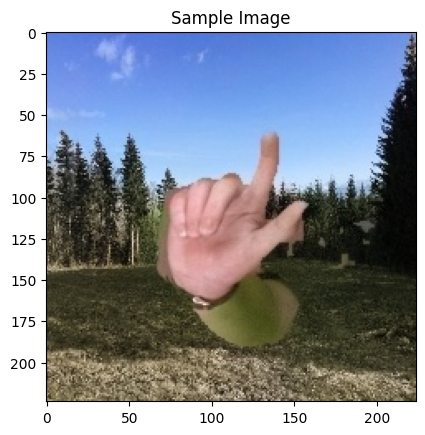

XY coordinates:
 [[0.4032321  0.6022063 ]
 [0.47729522 0.5941586 ]
 [0.54359394 0.56516826]
 [0.5835606  0.5246531 ]
 [0.65014106 0.4770282 ]
 [0.5429986  0.45468754]
 [0.5709921  0.3891471 ]
 [0.57556593 0.35455373]
 [0.5725018  0.30996478]
 [0.4921493  0.43216088]
 [0.49231493 0.4378542 ]
 [0.48207262 0.4820245 ]
 [0.46783337 0.5489965 ]
 [0.42643425 0.43815818]
 [0.4385136  0.44537118]
 [0.4308298  0.4914773 ]
 [0.42587948 0.5576391 ]
 [0.3764046  0.45731664]
 [0.3749434  0.4644506 ]
 [0.37304303 0.49662802]
 [0.37875524 0.5464224 ]]


In [65]:
#visualizing the dataloader to make sure I understand what each one is

# Get one batch
batch = next(iter(train_loader))
images = batch["image"]       # shape: (B, C, H, W)
xys = batch["xy"]           # shape: (B, N, 3)
# camera = batch["camera_idx"]
# frame_num = batch["frame_num"]
# Pick the first sample in the batch
img = images[0].permute(1, 2, 0).numpy()  # convert from (C,H,W) -> (H,W,C)
xy = xys[0].numpy()                     # (N, 3)
plt.imshow(img)
plt.title("Sample Image")
plt.show()
print("XY coordinates:\n", xy)
# print("\ncamera: ", camera[0])
# print("\nframe_num: ", frame_num[0])

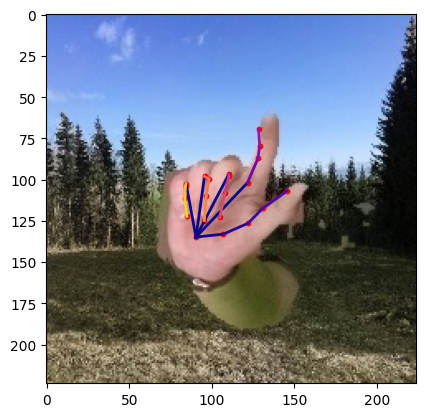

In [67]:
#check to make sure the 2D coordinates are being properly converted to image space
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),        # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),        # Index
    (0, 9), (9,10), (10,11), (11,12),      # Middle
    (0,13), (13,14), (14,15), (15,16),     # Ring
    (0,17), (17,18), (18,19), (19,20)      # Pinky
]

# Plot
plt.imshow(img)
plt.scatter(xy[:, 0]*224, xy[:, 1]*224, c='red', s=10)
# Draw connections
for (i, j) in connections:
    plt.plot(
        [xy[i, 0]*224, xy[j, 0]*224],
        [xy[i, 1]*224, xy[j, 1]*224],
        color=plt.cm.plasma(i / 21), linewidth=2
    )
plt.show()

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [68]:
#The VERY BASIC model

class CNN_Keypoint(nn.Module):
    def __init__(self, num_keypoints=21):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # compute the flattened feature size after conv + pool
        # input: [3,224,224] --> after pool1: [16,112,112]
        # after conv2: [32,112,112]
        # after pool2: [32,56,56]
        # after conv3: [64,56,56]
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_keypoints * 2)  # x and y for each keypoint

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # [16,112,112]
        x = self.pool(F.relu(self.conv2(x)))   # [32,56,56]
        x = F.relu(self.conv3(x))              # [64,56,56]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(x.size(0), -1, 2) # output shape: [B, num_keypoints, 2]

In [69]:
def train_net(net, batch_size=32, learning_rate=0.004, num_epochs=30):

    ########################################################################
    # use GPU to make things faster
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    ########################################################################
    # Define the Loss function and optimizer
    # Optimizer will be SGD with Momentum.
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/validation error/loss
    #train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    #val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    print("Training Started")
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        net.train()
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        total_correct = 0
        total_samples = 0

        for batch in train_loader:
            # Get the inputs
            imgs = batch["image"].to(device)
            coords = batch["xy"].to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            imgs = imgs.float()
            coords = coords.float()
            outputs = net(imgs)
            loss = criterion(outputs, coords)
            loss.backward()
            optimizer.step()

            # Calculate the statistics
            total_train_loss += loss.item() * imgs.size(0)
            total_samples += imgs.size(0)

        train_loss[epoch] = total_train_loss / total_samples

        net.eval()
        val_total_loss = 0.0
        val_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                imgs = batch["image"].to(device)
                coords = batch["xy"].to(device)
                outputs = net(imgs)
                loss = criterion(outputs, coords)
                val_total_loss += loss.item()*imgs.size(0)
                val_samples += imgs.size(0)

        val_loss[epoch] = val_total_loss / val_samples

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss[epoch]:.4f} | "
              f"Val loss: {val_loss[epoch]:.4f}")

        # Save the current model (checkpoint) to a file
        torch.save(net.state_dict(), f"model_epoch_{epoch+1}.pth")

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later

    #np.savetxt("train_err.csv", train_err)
    np.savetxt("train_loss.csv", train_loss)
    #np.savetxt("val_err.csv", val_err)
    np.savetxt("val_loss.csv", val_loss)

In [70]:
#checking that types are what they should be...
sample = train_dataset[0]
print("Keys:", sample.keys())
print("image type:", type(sample["image"]))
print("xy type:", type(sample["xy"]))
print(sample["xy"])

Keys: dict_keys(['image', 'xy'])
image type: <class 'torch.Tensor'>
xy type: <class 'torch.Tensor'>
tensor([[0.4060, 0.6795],
        [0.4942, 0.5891],
        [0.5407, 0.5173],
        [0.5724, 0.4510],
        [0.6068, 0.3846],
        [0.4529, 0.4142],
        [0.4898, 0.3736],
        [0.5149, 0.4084],
        [0.5311, 0.4852],
        [0.4119, 0.3966],
        [0.4654, 0.3795],
        [0.4975, 0.4251],
        [0.5189, 0.5022],
        [0.3744, 0.4151],
        [0.4367, 0.3934],
        [0.4746, 0.4428],
        [0.4870, 0.5210],
        [0.3560, 0.4366],
        [0.3891, 0.3904],
        [0.4360, 0.3823],
        [0.5019, 0.3937]])


In [71]:
my_net = CNN_Keypoint()
train_net(my_net, num_epochs=5)

Training Started
Epoch 1/5 | Train loss: 0.0535 | Val loss: 0.0091
Epoch 2/5 | Train loss: 0.0086 | Val loss: 0.0083
Epoch 3/5 | Train loss: 0.0082 | Val loss: 0.0081
Epoch 4/5 | Train loss: 0.0080 | Val loss: 0.0080
Epoch 5/5 | Train loss: 0.0078 | Val loss: 0.0078
Finished Training
Total time elapsed: 2327.19 seconds


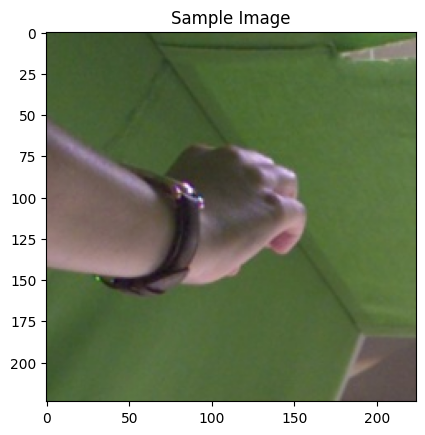

XY coordinates:
 [[0.40583432 0.6090252 ]
 [0.35982865 0.57899326]
 [0.36904657 0.5634268 ]
 [0.44892517 0.58158535]
 [0.56396824 0.63149005]
 [0.47031108 0.3532215 ]
 [0.5371942  0.3491836 ]
 [0.562337   0.4214935 ]
 [0.56808317 0.5387571 ]
 [0.58098656 0.3595475 ]
 [0.6203636  0.39500433]
 [0.6155861  0.47977597]
 [0.59436846 0.5960771 ]
 [0.66661745 0.42289189]
 [0.68461686 0.43205082]
 [0.6687708  0.5126426 ]
 [0.6181787  0.6130232 ]
 [0.7138414  0.5017923 ]
 [0.7315335  0.5139069 ]
 [0.7081692  0.55610806]
 [0.6560147  0.61156243]]


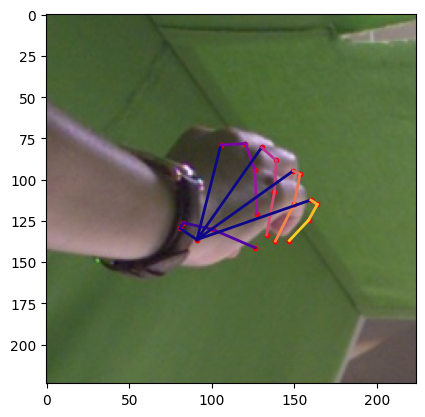

In [72]:

# Get one batch
batch = next(iter(train_loader))
images = batch["image"] # shape: (B, C, H, W)
xys = batch["xy"] # shape: (B, N, 3)

img = images[0].permute(1, 2, 0).numpy()  # convert from (C,H,W) -> (H,W,C)
xy = xys[0].numpy()                     # (N, 3)
plt.imshow(img)
plt.title("Sample Image")
plt.show()
print("XY coordinates:\n", xy)

#check to make sure the 2D coordinates are being properly converted to image space
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),        # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),        # Index
    (0, 9), (9,10), (10,11), (11,12),      # Middle
    (0,13), (13,14), (14,15), (15,16),     # Ring
    (0,17), (17,18), (18,19), (19,20)      # Pinky
]

# Plot
plt.imshow(img)
plt.scatter(xy[:, 0]*224, xy[:, 1]*224, c='red', s=10)
# Draw connections
for (i, j) in connections:
    plt.plot(
        [xy[i, 0]*224, xy[j, 0]*224],
        [xy[i, 1]*224, xy[j, 1]*224],
        color=plt.cm.plasma(i / 21), linewidth=2
    )
plt.show()